# Multi armed Bandit
This code is the reimplementation of the one included with the paper Neural Contextual Bandits with UCB-based Exploration by Zhou et al.
Code for the original paper is located in: https://github.com/uclaml/NeuralUCB

This first code block has the dataloader class and the multi armed bandit class. The bandit class utilizes the data to create the bandits which will be used by the UCB algorithms later.

In [2]:
from sklearn.datasets import fetch_openml
from sklearn.utils import shuffle
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import normalize
import numpy as np

class DataLoader:
    def __init__(self, name, batch_size=32, is_shuffle=True, seed=None):
        # Fetch data
        if name == 'mnist':
            self.X, self.y = fetch_openml('mnist_784', version=1, return_X_y=True)
        elif name == 'shuttle':
            self.X, self.y = fetch_openml('shuttle', version=1, return_X_y=True)
        else:
            raise RuntimeError('Dataset does not exist')
        
        # Replace NaNs with -1 and normalize
        self.X[np.isnan(self.X)] = -1
        self.X = normalize(self.X)
        
        # Shuffle data
        if is_shuffle:
            self.X, self.y = shuffle(self.X, self.y, random_state=seed)
            print('Shuffling data')
        
        self.batch_size = batch_size
        self.indices = np.arange(self.X.shape[0])
        self.current_index = 0
        
        
        self.y_arm = OrdinalEncoder(dtype=int).fit_transform(self.y.values.reshape((-1, 1)))

    #Handling batches
    def next_batch(self):
        if self.current_index >= self.X.shape[0]:
            self.current_index = 0  # Reset for next epoch
            raise StopIteration  
        
        batch_indices = self.indices[self.current_index:self.current_index + self.batch_size]
        self.current_index += self.batch_size
        
        return self.X[batch_indices], self.y_arm[batch_indices]
    
# Creates the multi armed bandit
class Bandit_multi:
    def __init__(self, name, batch_size=32, is_shuffle=True, seed=None):
        self.loader = DataLoader(name, batch_size, is_shuffle, seed)
        self.cursor = 0
        self.size = self.loader.X.shape[0]
        self.n_arm = np.max(self.loader.y_arm) + 1
        self.dim = self.loader.X.shape[1] * self.n_arm
        self.act_dim = self.loader.X.shape[1]

    def step(self):
        X, y_arm_batch = self.loader.next_batch()
        self.cursor += len(y_arm_batch)  
        X_output = np.zeros((self.n_arm, self.dim))
        
        for a in range(self.n_arm):
            X_output[a, a * self.act_dim:a * self.act_dim + self.act_dim] = X
        
        rwd = np.zeros((self.n_arm,))
        for arm in y_arm_batch:
            rwd[arm[0]] = 1  
        
        return X_output, rwd

    def finish(self):
        return self.cursor >= self.size

    def reset(self):
        self.cursor = 0
        self.loader.current_index = 0  


## NeuralUCB
This code block has the creation of the neural network and the implementation of the Neural UCB class

In [ ]:
import scipy as sp
import torch
import torch.nn as nn
import torch.optim as optim

#Neural Network
class Network(nn.Module):
    def __init__(self, dim, hidden_size=100):
        super(Network, self).__init__()
        self.fc1 = nn.Linear(dim, hidden_size)
        self.activate = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, 1)
    def forward(self, x):
        return self.fc2(self.activate(self.fc1(x)))

#Implementation of the Neural UCB
class NeuralUCBDiag:
    def __init__(self, dim, lamdba=1, nu=1, hidden=100):
        self.func = Network(dim, hidden_size=hidden).cuda()
        self.context_list = []
        self.reward = []
        self.lamdba = lamdba
        self.total_param = sum(p.numel() for p in self.func.parameters() if p.requires_grad)
        self.U = lamdba * torch.ones((self.total_param,)).cuda()
        self.nu = nu

    #Select function correspond to the action of selecting an arm
    def select(self, context):
        tensor = torch.from_numpy(context).float().cuda()
        mu = self.func(tensor)
        g_list = []
        sampled = []
        ave_sigma = 0
        ave_rew = 0
        for fx in mu:
            self.func.zero_grad()
            fx.backward(retain_graph=True)
            g = torch.cat([p.grad.flatten().detach() for p in self.func.parameters()])
            g_list.append(g)
            sigma2 = self.lamdba * self.nu * g * g / self.U
            sigma = torch.sqrt(torch.sum(sigma2))

            sample_r = fx.item() + sigma.item()

            sampled.append(sample_r)
            ave_sigma += sigma.item()
            ave_rew += sample_r
        arm = np.argmax(sampled)
        self.U += g_list[arm] * g_list[arm]
        return arm, g_list[arm].norm().item(), ave_sigma, ave_rew

    #Used for the neural network
    def train(self, context, reward):
        self.context_list.append(torch.from_numpy(context.reshape(1, -1)).float())
        self.reward.append(reward)

        #SGD optimizer
        optimizer = optim.SGD(self.func.parameters(), lr=1e-2, weight_decay=self.lamdba)
        length = len(self.reward)
        index = np.arange(length)
        np.random.shuffle(index)
        cnt = 0
        tot_loss = 0
        while True:
            batch_loss = 0
            for idx in index:  #Learning process with back propagation
                c = self.context_list[idx]
                r = self.reward[idx]
                optimizer.zero_grad()
                delta = self.func(c.cuda()) - r
                loss = delta * delta
                loss.backward()
                optimizer.step()
                batch_loss += loss.item()
                tot_loss += loss.item()
                cnt += 1
                if cnt >= 1000:
                    return tot_loss / 1000
            if batch_loss / length <= 1e-3:
                return batch_loss / length


This serves as the run method. In here you can change the values of size, dataset, shuffle, seed, nu, lambda, hidden and batch size.
This code also plots the cumulative reward for Neural UCB on the dataset chosen.

Shuffling data
0: 1.000, 9.799e-04, 1.153e+00, 1.140e+00, 1.770e+00
100: 65.000, 4.172e-03, 3.309e+00, 1.606e+00, 2.391e+00
200: 109.000, 2.155e-03, 4.193e+00, 1.650e+00, 2.057e+00
300: 152.000, 3.702e-03, 4.364e+00, 1.492e+00, 1.657e+00
400: 181.000, 2.452e-03, 4.909e+00, 1.273e+00, 1.133e+00
500: 214.000, 2.968e-03, 5.279e+00, 1.242e+00, -1.244e-01
600: 235.000, 2.360e-03, 5.485e+00, 1.295e+00, 8.987e-01
700: 261.000, 3.224e-03, 4.272e+00, 1.133e+00, 1.337e+00
800: 281.000, 5.737e-03, 5.821e+00, 9.037e-01, 3.308e-01
900: 307.000, 4.202e-03, 6.008e+00, 1.027e+00, 2.165e+00


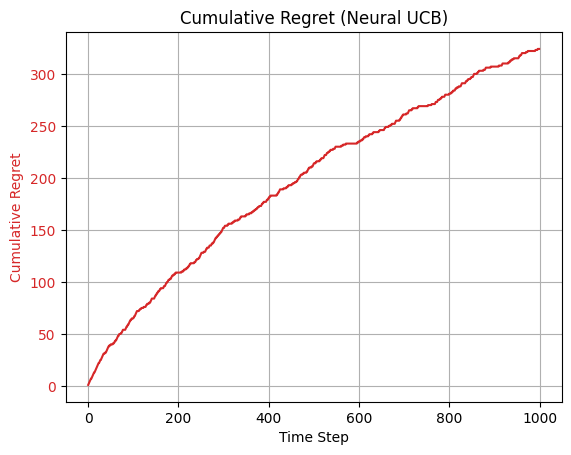

In [4]:
import time
import matplotlib.pyplot as plt


if __name__ == '__main__':
    size = 1000
    dataset = 'mnist'
    is_shuffle = True
    seed = 0
    nu = 0.01
    lamdba = 0.001
    hidden = 100
    batch_size = 32

    use_seed = None if seed == 0 else seed
    b = Bandit_multi(dataset, is_shuffle)
    l = NeuralUCBDiag(b.dim, lamdba, nu, hidden)
    bandit_info = '{}'.format(dataset)

    regrets = []
    summ = 0
    for t in range(min(size, b.size)):
        context, rwd = b.step()

        # Train in batches
        for batch in range(0, len(context), batch_size):
            context_batch = context[batch:batch + batch_size]
            rwd_batch = rwd[batch:batch + batch_size]  # Adjust if necessary
            
            arm_select, nrm, sig, ave_rwd = l.select(context_batch)
            r = rwd_batch[arm_select]
            reg = np.max(rwd_batch) - r
            summ += reg
            
            if t < 2000:
                loss = l.train(context_batch[arm_select], r)
            else:
                if t % 100 == 0:
                    loss = l.train(context_batch[arm_select], r)

        regrets.append(summ)
        if t % 100 == 0:
            print(f'{t}: {summ:.3f}, {loss:.3e}, {nrm:.3e}, {sig:.3e}, {ave_rwd:.3e}')

    # write regrets to a file, this helps if you encounter problems while running the code. You have the ability to see the cumulative regret
    path = '{}_{}'.format(bandit_info, time.time())
    with open(path, 'w') as fr:
        for i in regrets:
            fr.write(str(i) + "\n")
    
    fig, ax1 = plt.subplots()
    ax1.set_xlabel('Time Step')
    ax1.set_ylabel('Cumulative Regret', color='tab:red')
    ax1.plot(regrets, color='tab:red', label='Cumulative Regret')
    ax1.tick_params(axis='y', labelcolor='tab:red')
    plt.title('Cumulative Regret (Neural UCB)')
    ax1.grid()
    plt.show()

## LinUCB
This contains the Linear UCB class which was implemented as a baseline class to compare the neural ucb algorithm.

In [5]:
class LinearUCB:
    def __init__(self, bandit: Bandit_multi, alpha=1.0):
        self.bandit = bandit
        self.alpha = alpha  
        self.n_arm = bandit.n_arm
        self.counts = np.zeros(self.n_arm)  
        self.total_rewards = np.zeros(self.n_arm)  # rewards for each arm
        self.theta = np.zeros((self.n_arm, self.bandit.dim))  # weights

    def select_arm(self):
        # upper confidence bounds for each arm
        ucb_values = np.zeros(self.n_arm)
        for arm in range(self.n_arm):
            if self.counts[arm] == 0:
                # give a high value to untried arms
                ucb_values[arm] = float('inf')
            else:
                avg_reward = self.total_rewards[arm] / self.counts[arm]
                delta = np.sqrt((self.alpha * np.log(sum(self.counts))) / self.counts[arm])
                ucb_values[arm] = avg_reward + delta
        
        return np.argmax(ucb_values)

    def update(self, arm, reward):
        # counts and total rewards for the chosen arm
        self.counts[arm] += 1
        self.total_rewards[arm] += reward

    def run(self):
        while not self.bandit.finish():
            # Get the current context and select an arm
            context, _ = self.bandit.step()
            arm = self.select_arm()

            
            reward = self.bandit.y[arm]  
            self.update(arm, reward)

The run method for LinUCB. Variables that can be updated are size, dataset, shuffle, seed nu, and lambda.

In [6]:
import time

if __name__ == "__main__":
    size = 1000
    dataset = 'mnist'
    is_shuffle = True
    seed = 0
    nu = 0.01
    lamdba = 0.0001
    bandit = Bandit_multi(dataset, is_shuffle, seed)
    

    
    
    bandit_info = '{}'.format(dataset)
    ucb = LinearUCB(bandit)  # initialization
    average_rewards = []  
    regrets_lin = []

    summ = 0
    for t in range(min(size, bandit.size)):
        context, rwd = bandit.step()
        arm_select = ucb.select_arm()  # Select arm using LinearUCB
        r = rwd[arm_select]  
        reg = np.max(rwd) - r #calculate regret
        summ += reg
        ucb.update(arm_select, r)  # update with the received reward
        average_rewards.append(np.mean(rwd))
        regrets_lin.append(summ)

        if t % 100 == 0:
            print('{}: {:.3f}'.format(t, summ))

    # write regrets to a file
    path = '{}_{}'.format(bandit_info, time.time())
    with open(path, 'w') as fr:
        for i in regrets_lin:
            fr.write(str(i) + "\n")


0: 1.000
100: 91.000
200: 183.000
300: 273.000
400: 369.000
500: 459.000
600: 550.000
700: 638.000
800: 731.000
900: 823.000


Separated the ploting code from the run method. Here we plot the regret for LinUCB

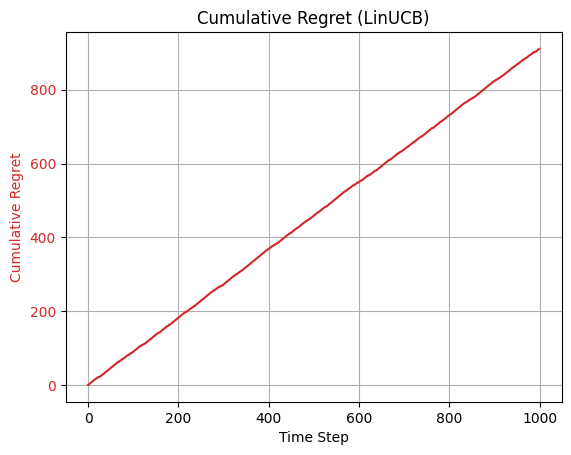

In [7]:
import matplotlib.pyplot as plt

# figure and set of subplots
fig, ax1 = plt.subplots()

# Plotting cumulative regret
ax1.set_xlabel('Time Step')
ax1.set_ylabel('Cumulative Regret', color='tab:red')
ax1.plot(regrets_lin, color='tab:red', label='Cumulative Regret')
ax1.tick_params(axis='y', labelcolor='tab:red')



plt.title('Cumulative Regret (LinUCB)')
ax1.grid()


plt.show()

## Comparative plots
Here we plot both regrets to compare the results.

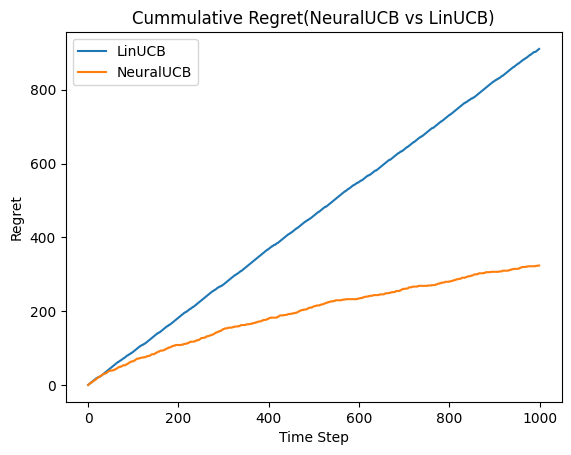

In [8]:

plt.plot(regrets_lin, label='LinUCB')
plt.plot(regrets, label='NeuralUCB')


plt.title('Cummulative Regret(NeuralUCB vs LinUCB)')
plt.ylabel('Regret')
plt.xlabel('Time Step')


plt.legend()

# Show the plot
plt.show()

To create the requirements file which includes the environment setup.

In [9]:
!pip freeze > requirements.txt